# This is a quick-start file for the assignment. Feel free to erase cells you don't need.

In [1]:
# Your environment is probably missing some packages. We will check and, if necessary, install.
# https://pypi.org/project/yfinance
import pip
from pip._internal.utils.misc import get_installed_distributions
pkgs = ''.join(str(get_installed_distributions(local_only=True)))
if "yfinance" not in pkgs:
    !pip install yfinance
if "lxml" not in pkgs:
    !pip install lxml 

In [2]:
# Now we can import yfinance
import yfinance as yf
import pandas as pd
from pathlib import Path

In [3]:
# Let's define some useful constants
START = "2000-07-03"
END   = "2020-08-10"

TICKERS = ['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AKAM', 'AMD', 'ANSS', 'APH', \
           'AVIFY', 'BA', 'BCE', 'CAJ', 'CDNS', 'CERN', 'CGNX', 'CHKP', 'CHL', \
           'CHU', 'CSCO', 'CSGP', 'CTL', 'CTSH', 'CTXS', 'DASTY', 'DTEGY', 'ERIC', \
           'FDS', 'FICO', 'FISV', 'GD', 'GE', 'GIB', 'GLW', 'HEI', 'HPQ', 'IBM', \
           'IFNNY', 'INFY', 'INTC', 'INTU', 'JKHY', 'KKPNY', 'KLAC', 'KYOCY', 'LHX', \
           'LMT', 'LOGI', 'LRCX', 'MCHP', 'MRVL', 'MSFT', 'MSI', 'MU', 'MXIM', \
           'NICE', 'NOC', 'NOK', 'NTTYY', 'NVDA', 'ORAN', 'ORCL', 'OTEX', 'PAYX', \
           'PTC', 'QCOM', 'RCI', 'ROP', 'SAP', 'SCMWY', 'SFTBF', 'SKM', 'SNPS', \
           'STM', 'SWKS', 'T', 'TDY', 'TEF', 'TER', 'TLK', 'TLSYY', 'TRMB', 'TSM', \
           'TTDKY', 'TU', 'TXN', 'TYL', 'VIV', 'VOD', \
           'VRSN', 'VZ', 'WDC', 'XLNX', 'ZBRA']

DATAFILE_NAME = "data.pickle"

# https://www.devdungeon.com/content/colorize-terminal-output-python
BOLD  = '\033[1m'
ULINE = '\033[4m'
BLUE  = '\033[34m'
RED   = '\033[31m'
RESET = '\033[0m'

In [4]:
len(TICKERS), type(TICKERS)

(94, list)

## You need to consult `pandas` documentation https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html to complete this assignment

In [5]:
# It's practical to download data from Yahoo!Finance just once and keep a local copy
if Path(DATAFILE_NAME).is_file(): # check if we got the datafile already
    data = pd.read_pickle(DATAFILE_NAME) # read it
else:
    data = yf.download(tickers=TICKERS, start=START, end=END, group_by='ticker', auto_adjust=True)
    data.to_pickle(DATAFILE_NAME) # save localy

## 1. Find a stock among all 94 in TICKERS that had the biggest HIGH/LOW difference during one day. Whats is the name of the company? What date was it? How big was the swing in percent?

In [6]:
# short solution
HL_diff = pd.DataFrame()
for ticker in TICKERS:
    HL_diff[ticker] = data[(ticker,'High')] - data[(ticker,'Low')]

comp_name_1 = HL_diff.max().idxmax()
date = HL_diff[comp_name_1].idxmax()
d = data.loc[date, comp_name_1]

swing = (d.High - d.Low) / ((d.High + d.Low))
print(BOLD, BLUE, comp_name_1, date.day, date.month_name(), date.year, 'volatility: {:.2f}%'.format(swing*100), RESET)

  CSGP 29 July 2020 volatility: 8.91% 


## 2. For that company find the month when standard deviation in Close value was the lowest.  Print out the month and the year.

In [7]:
# short solution
def st_dev (in_data):
    mean = sum(in_data) / len(in_data)
    variance  = sum((x-mean)**2 for x in in_data) / (len(in_data)-1)
    return variance**(1./2.)

the_month = data[(comp_name_1, 'Close')].groupby(pd.Grouper(freq='1M')).apply(st_dev).idxmin()
print(BOLD, BLUE, the_month.month_name(), the_month.year, RESET)

  January 2004 


## 3. The volatility of a stock is the fluctuation of price during a day. Find the company among all in TICKERS with the highest _median_ volatility in percent during the month you identified in (2). What is the name of this company?

In [8]:
def medianF (in_data):
    dt = list(in_data.sort_values()) 
    n = len(dt)
    if n % 2 == 0:  
        return (dt[n//2] + dt[n//2 - 1])/2
    else: 
        return dt[n//2] 

from datetime import timedelta
ds = pd.Timestamp(the_month.year, the_month.month, 1)
de = pd.Timestamp(ds.year, ds.month + 1, 1) - timedelta(days=1)
print('from ', ds.date(), ' to ', de.date())

dm = data.loc[ds:de]
stocks = pd.DataFrame()
for stock in TICKERS:
    high, low = dm[(stock,'High')], dm[(stock,'Low')]
    stocks[stock] = 2 * (high - low) / (high + low)
comp_name_2 = stocks.apply(medianF).idxmax()
print(BOLD, BLUE, comp_name_2, RESET)

from  2004-01-01  to  2004-01-31
  AVIFY 


## 4. Create a candlestick chart for the two stocks you found in (1) and (3) and for the month you identified. Make sure that x-axis displays the dates.

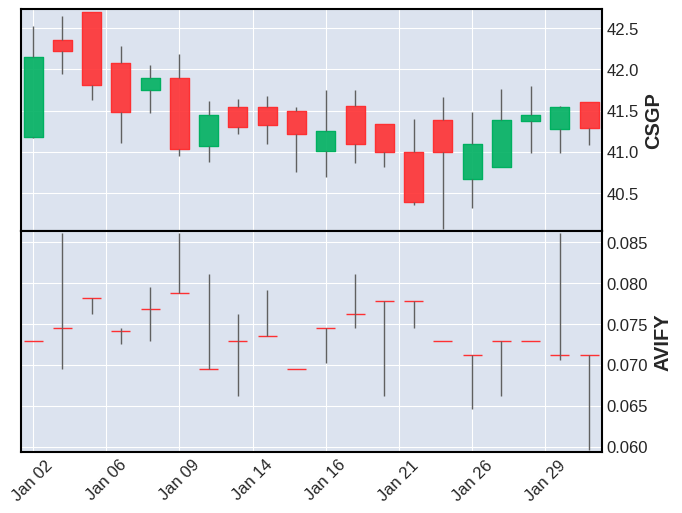

In [9]:
import mplfinance as mpf
from matplotlib.ticker import NullFormatter
fig = mpf.figure(figsize=(7.5,5.75)) 
fig.subplots_adjust(hspace=0)
ax1 = fig.subplot(211)
ax2 = fig.subplot(212)

for cmp, ax in zip([comp_name_1, comp_name_2], [ax1, ax2]):
    mpf.plot(data.loc[ds: de][cmp], ax=ax,type='candle',style='yahoo', tight_layout=True, ylabel=cmp) 
ax1.get_xaxis().set_major_formatter(NullFormatter())

In [10]:
data.loc[ds:de,([comp_name_1,comp_name_2], slice(None))].head()

CSGP                                               AVIFY  \
                 Open       High        Low      Close   Volume      Open   
Date                                                                        
2004-01-02  41.180000  42.520000  41.169998  42.150002  45300.0  0.072859   
2004-01-05  42.349998  42.650002  41.939999  42.220001  60300.0  0.074515   
2004-01-06  42.700001  42.700001  41.630001  41.810001  71100.0  0.078158   
2004-01-07  42.070000  42.279999  41.110001  41.480000  92100.0  0.074184   
2004-01-08  41.750000  42.049999  41.470001  41.900002  86700.0  0.076834   

                                                    
                High       Low     Close    Volume  
Date                                                
2004-01-02  0.072859  0.072859  0.072859   10000.0  
2004-01-05  0.086107  0.069548  0.074515  664000.0  
2004-01-06  0.078158  0.076171  0.078158  349000.0  
2004-01-07  0.074515  0.072528  0.074184  465000.0  
2004-01-08  0.079483  0.072859  0.076834   67000.0

## 5. Write your reflections on the assignment. What was easy? What was hard? How much time did you spend on the assignment?

In [12]:
idx = pd.IndexSlice
OC_diff = pd.DataFrame()
for ticker in TICKERS:
    OC_diff[ticker] = (data.loc[:,idx[ticker,'Open']] - data.loc[:,idx[ticker,'Close']]).apply(abs)
print(BLUE, 'How many days there are when Open equals Close?', RESET)
print(OC_diff.apply(lambda i: i == 0.).sum().sort_values())

 How many days there are when Open equals Close? 
AAPL       13
INTU       20
LRCX       20
GD         23
QCOM       23
         ... 
SCMWY     381
KKPNY     498
TLSYY     591
SFTBF    2468
AVIFY    2821
Length: 94, dtype: int64
